# Analysis of Survey Data I: Scale Construction (Exploratory Factor Analysis)

In here, I conduct an exploratory factor analysis on the survey data in order to...
... To find the ideal number of factors that explain the answers on the 73 items, I will conduct an exploratory factor analysis (EFA).


## Import Packages And Configure Settings


In [86]:
# Base modules
import pandas as pd
import numpy as np
import copy
import itertools

# Visualization modules
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Data analysis modules
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
# sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection

# own library
import efa_utils.efa_utils_functions

# matplotlib settings
%matplotlib inline
plt.style.use('fivethirtyeight')

I will be using efa_utils, a package I wrote to make exploratory factor analysis with the factor_analysis package easier. It is available on [GitHub](https://github.com/MWiechmann/efa_utils).

In [87]:
help(efa_utils)

Help on package efa_utils:

NAME
    efa_utils

DESCRIPTION
    EFA Utilities (efa_utils)
    Custom utility functions for exploratory factor analysis with the factor_analyzer package.
    
    Functions:
    reduce_multicoll: Function to reduce multicollinearity in a dataset (intended for EFA). Uses the determinant of the correlation matrix to determine if multicollinearity is present. If the determinant is below a threshold (0.00001 by default), the function will drop the variable with the highest VIF until the determinant is above the threshold.
    kmo_check: Function to check the Kaiser-Meyer-Olkin measure of sampling adequacy (KMO) and Bartlett's test of sphericity for a dataset. Requires statsmodels package. Main use is to print a report of total KMO and item KMOs, but can also return the KMO values.
    parallel_analysis: Function to perform parallel analysis to determine the number of factors to retain.
    iterative_fa: Function to perform iterative exploratory factor analysi

## Read in and prepare the dataset


In [88]:
# Survey response data
aiss = pd.read_csv("data/combined_data.csv",
                   index_col=0).reset_index(drop=True)
aiss.head(3)


,response_id,story_id,prompt_label,preset_label,sample,ss_coh_1,ss_coh_2,ss_coh_3,ss_coh_4,ss_coh_5,...,start,end,duration_in_sec,recorded,ss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [89]:
# Question texts
items_descr = pd.read_csv("data/description_items.csv", index_col=0)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

print(f"Items_descr\n\nHead:\n{items_descr.head(3)}")
print(f"\nIndex:\n{items_descr.index}")


Items_descr

Head:
item_label
Qual_Check_1                    The story I just read, began with...
Qual_Check_1_DO    The story I just read, began with... - Display...
ss_coh_1           I had a hard time making sense of what was goi...
Name: item description, dtype: object

Index:
Index(['Qual_Check_1', 'Qual_Check_1_DO', 'ss_coh_1', 'ss_coh_2', 'ss_coh_3',
       'ss_coh_4', 'ss_coh_5', 'ss_coh_6', 'ss_coh_7', 'ss_coh_8', 'ss_coh_9',
       'ss_coh_10', 'ss_coh_11', 'ss_coh_12', 'ss_conch_1', 'ss_conch_2',
       'ss_conch_3', 'ss_conch_4', 'ss_conch_5', 'ss_conch_6', 'ss_conch_7',
       'ss_conch_8', 'ss_cre_1', 'ss_cre_2', 'ss_cre_3', 'ss_cre_4',
       'ss_cre_5', 'ss_cre_6', 'ss_cre_7', 'ss_cre_8', 'ss_cre_9', 'ss_cre_10',
       'ss_cre_11', 'ss_cre_12', 'ss_qua_1', 'ss_qua_2', 'ss_qua_3',
       'ss_qua_4', 'ss_qua_5', 'ss_qua_6', 'ss_qua_7', 'ss_qua_8', 'ss_qua_9',
       'ss_rep_1', 'ss_rep_2', 'ss_rep_3', 'ss_rep_4', 'ss_rep_5', 'ss_rep_6',
       'ss_rep_7', 'ss_rep_8', 's

In [90]:
# Pull list of story scale item column names
# (will be useful later when we iterate over the items)
item_labels = list(items_descr.index)
# remove quality check items
item_labels.remove("Qual_Check_1")
item_labels.remove("Qual_Check_1_DO")
item_labels.remove("qual_check_2")


### Check Missing Data Patterns


In [91]:
missing = aiss[item_labels].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

Top 5 cols with missing data per col:
ss_pac_9     3
ss_qua_2     3
ss_rep_8     3
ss_coh_2     3
ss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
0       0
216     0
dtype: int64


Only 3 cases have missing data. In this case things are relatively straightforward - I will just drop those cases. If missing data was more common with small amounts of missing data per case, I would have considered imputation.


In [92]:
print(
    f"Cases with missing data on AISS items: {aiss[item_labels].isna().any(axis=1).sum()}")

aiss.dropna(subset=item_labels, inplace=True)
print("Dropped cases with missing data.")

print(f"\nCase count after dropping missing data: {aiss.shape[0]}")
print(f"Community sample size: {aiss[aiss['sample'] == 'Community'].shape[0]}")
print(f"Panel sample size: {aiss[aiss['sample'] == 'Panel'].shape[0]}")


Cases with missing data on AISS items: 3
Dropped cases with missing data.

Case count after dropping missing data: 323
Community sample size: 162
Panel sample size: 161


## EFA: Preliminary Data Checks

### Investigating Correlations

EFA assumes that there is enough covariance between the variables to extract factors. A general rule of thumb is that there should be sufficient correlations > .30 (e.g. [Tabachnik, Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097?view=educator)). At the same time, correlations should not be _too_ high. Multicollinearity and singularity can make it impossible to determine the unique contribution of each variable to the factors ([Field, 2018](https://uk.sagepub.com/en-gb/eur/discovering-statistics-using-ibm-spss-statistics/book257672)). I will take a closer look at multicollenarity later, but the correlation matrix should give a good first impression.


In [93]:
items_corr = aiss[item_labels].corr()

# Number of correlations is (elements in correlation matrix - diagonal) /2
num_corrs = (items_corr.size - items_corr.shape[0])/2
print(f"Count of total correlations: {int(num_corrs)}")
print(
    f"Count of absolute correlations above 0.8: {int(((abs(items_corr) > 0.8).sum().sum() - items_corr.shape[0])/2)}")
print(
    f"Count of absolute correlations below 0.3: {int(((abs(items_corr) < 0.3).sum().sum() - items_corr.shape[0])/2)}")

# uhmm that are more extreme correlations than I would like
# but maybe subscales are fairly orthogonal?


Count of total correlations: 2628
Count of absolute correlations above 0.8: 1
Count of absolute correlations below 0.3: 1781


There are quite a few weak correlations with an absolute strength below .3 in this dataset. This is not necessarily a bad sign - there are still enough correlations > .3 and the factors might be fairly distinct. A graphical representation of the correlations will make things a bit clearer. But I will take a look at the single extremly high correlation first.


In [94]:
# list only correlations > .8
high_corrs = items_corr[items_corr > 0.8].stack().reset_index().rename(
    columns={"level_0": "var_1", "level_1": "var_2", 0: "corr"})
# remove diagonals
high_corrs = high_corrs[high_corrs["var_1"] != high_corrs["var_2"]]
# remove second half of correlations (duplicates)
high_corrs = high_corrs.iloc[:int(len(high_corrs)/2)]

print(f"Correlations above 0.8:\n{high_corrs}")

# Give out labels for the items
high_corr_item_labels = []
high_corr_item_labels.extend(high_corrs["var_1"].unique())
high_corr_item_labels.extend(high_corrs["var_2"].unique())
print("\n Labels for items:")
print(items_descr[high_corr_item_labels])


Correlations above 0.8:
       var_1     var_2      corr
33  ss_qua_1  ss_qua_3  0.804143

 Labels for items:
item_label
ss_qua_1     This story was enjoyable.
ss_qua_3    The story was fun to read.
Name: item description, dtype: object


2 story quality items correlate so strongly, that they are almost identical. I will diagnose multicollinearities later, and I expect one of these items to be dropped then.

##### Visual Representation of Absolute (!) Correlations

The following heatmap represent the _absolute strength_ of correlations (so _r_ = -.5 will receive the same color as _r_ = .5).


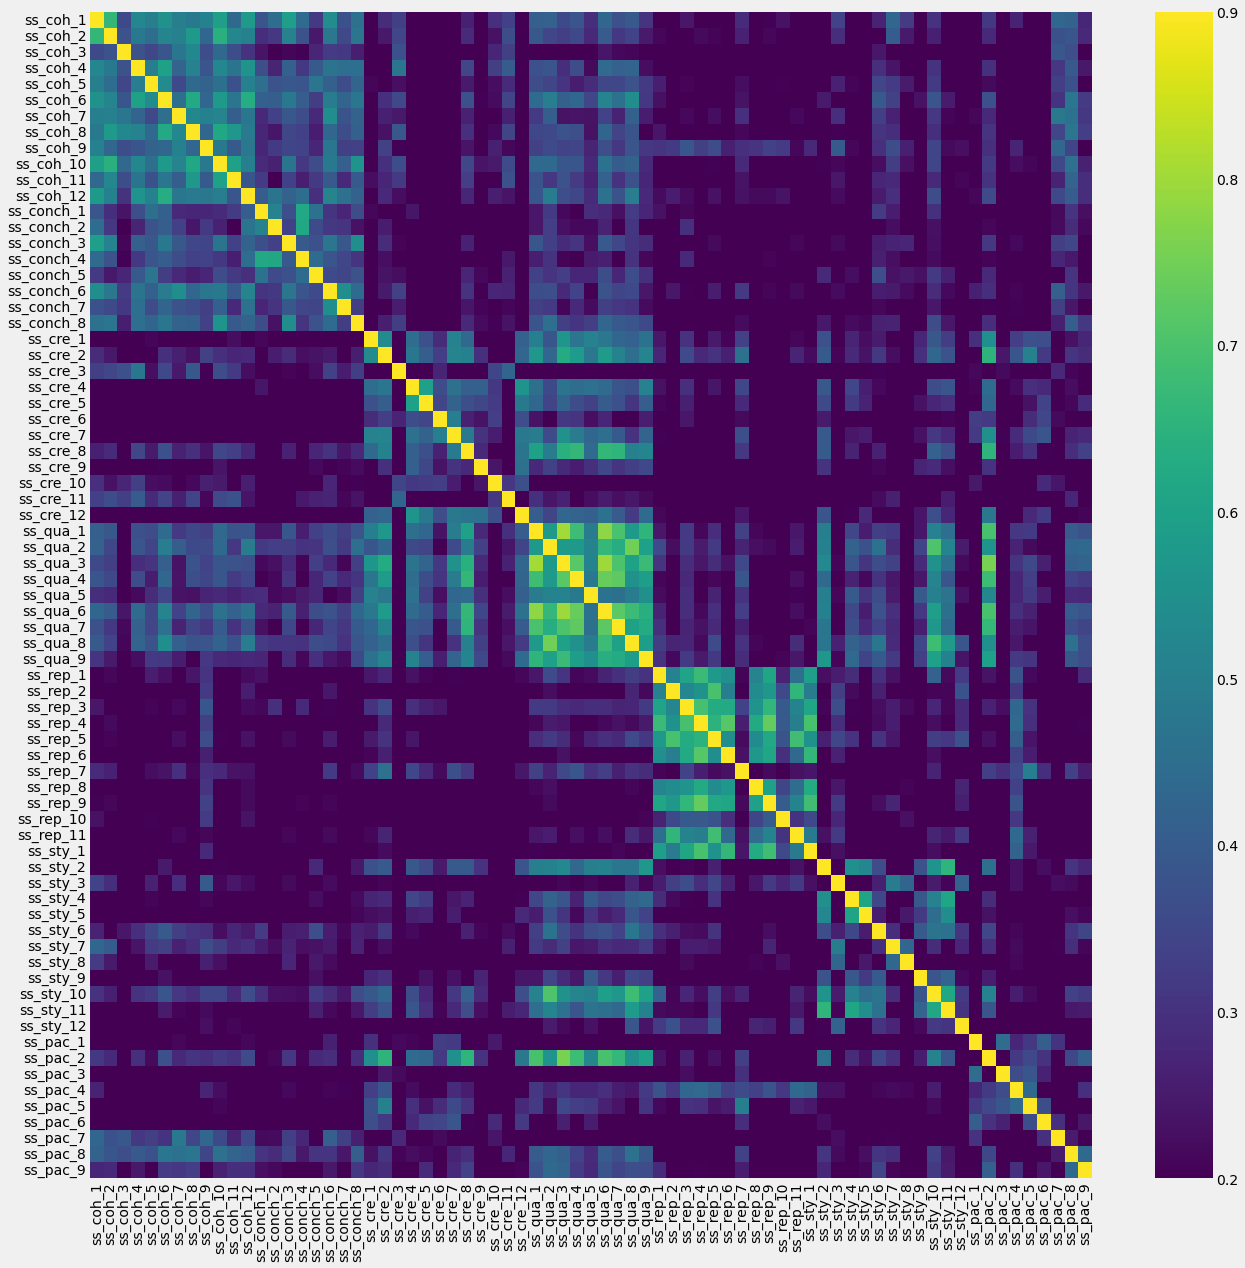

In [95]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.2, vmax=0.9)

# most item clusters are just surprising orthogonal (which is actually nice)


Most item clusters look fairly orthogonal (i.e. distinct). This would actually be quite nice for getting a simple structure in the EFA if this should hold true.


### Investigate Multicollinearity

I will be using the determinant of the correlation matrix to check for multicollinearity. A determinant < .00001 is usually seen as a sign for a a high degree of multicollinearity ([Tabachnick & Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097)).


In [96]:
print(f"Determinant of correlation matrix: {np.linalg.det(items_corr)}")


Determinant of correlation matrix: 3.527892546213652e-23


The determinant is far below .00001. This indicates not only a high degree of multicollinearity, but also a fair amount of redundancy among the items. Using the variance inflation factor (VIF) I will check for the individual items that are most problematic. In an iterative process, I will drop the items with the highest VIF from analysis until the determinant is above .00001.


In [97]:
# Apply function to obtain reduced list of items without multicollinearity for analysis
items_analysis = efa_utils.reduce_multicoll(
    aiss, item_labels, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 3.527892546213652e-23

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item ss_qua_3. VIF: 39.81
('The story was fun to read.')

Excluded item ss_coh_12. VIF: 31.08
('The story lacked logic.')

Excluded item ss_qua_6. VIF: 29.05
('I liked this story.')

Excluded item ss_coh_1. VIF: 26.94
('I had a hard time making sense of what was going on in the story.')

Excluded item ss_qua_1. VIF: 24.45
('This story was enjoyable.')

Excluded item ss_rep_4. VIF: 23.64
('In the story, the same things happened again and again.')

Excluded item ss_qua_8. VIF: 23.57
('The story was well-written.')

Excluded item ss_cre_4. VIF: 23.31
('The story was creative.')

Excluded item ss_sty_4. VIF: 22.65
('The text contained a broad vocabulary.')

Excluded item ss_conch_5. VIF: 22.20
('The descriptions of characters in the story were plausible.')

Excluded item ss_cre_2. VIF: 22.02
('The

### Check Sampling Adequacy (KMO)

Kaiser–Meyer–Olkin (KMO) measure of sampling adequacy is a measure of how well the data set can be described by a factor analysis model. It is a measure of the proportion of variance in the variables that is explained by the factors ([Kaiser & Rice, 1974](https://journals.sagepub.com/doi/10.1177/001316447403400115)). A high KMO indicates that correlation patterns are relatively compact and that the factors are well defined. A value of .6 is usually seen as a good threshold ([Tabachnik & Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097)).

| KMO  | Interpretation ([Kaiser & Rice, 1974](https://journals.sagepub.com/doi/10.1177/001316447403400115)) |
| ---- | --------------------------------------------------------------------------------------------------- |
| > .9 | Marvellous                                                                                          |
| > .8 | Meritorious                                                                                         |
| > .7 | Middling                                                                                            |
| > .6 | Mediocre                                                                                            |
| < .6 | Unacceptable                                                                                        |

Why did Kaiser & Rice ruin the pattern by not chosing a word starting with "M" for the last category? We'll never know...


In [98]:
# Check KMO
efa_utils.kmo_check(aiss, items_analysis, dropna_thre=0, check_item_kmos=True, return_kmos=False)


Overall KMO: 0.8613594159011393
All item KMOs are >.6


The KMO is .86. This is a very good value, indicating that the data is well suited for factor analysis.


## Running the EFA


### Determine the Number of Factors
As a first step, I will determine the optimal number of factors for explaining the variance in the responses to the items. I will be using the screeplot as well as a parallel analysis to determine the ideal number of factors ([Zwick & Velicer, 1986](https://www.researchgate.net/profile/Wayne-Velicer/publication/225083592_Comparison_of_5_rules_for_determining_the_number_of_components_to_retain/links/00b49518930d4067e4000000/Comparison-of-5-rules-for-determining-the-number-of-components-to-retain.pdf)).

If the methods disagree on the number of factors (or if the results are ambigous), I will examine all solutions and choose the one that seems most reasonable (which solution seems most clean & interpretable).

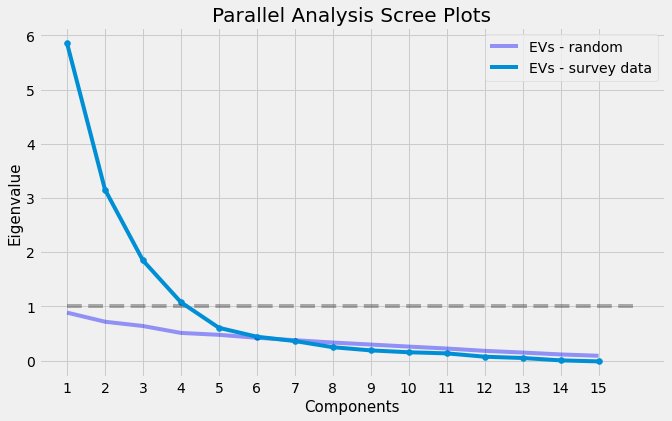

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.88				5.85
2	0.72				3.15
3	0.64				1.85
4	0.51				1.08
5	0.48				0.60
6	0.42				0.44
7	0.38				0.36
8	0.33				0.25
9	0.30				0.19
10	0.26				0.15
11	0.22				0.13
12	0.18				0.07
13	0.15				0.05
14	0.11				0.00
15	0.09				-0.02
Suggested number of factors based on parallel analysis: 6


In [99]:
efa_utils.parallel_analysis(aiss, items_analysis, return_rec_n=False)


Parallel analysis suggests 6 factors, but it is close so 5 factors might also be worth trying. The screeplot suggests either 4 or 5 factors. I will try 4-, 5- and 6-factor solutions and see which one seems most reasonable.

### 6 factor Solution


#### Deciding On Factor Rotation
As a first step, I am checking whether a orthogonal or oblique rotation is more appropriate. To his end, I will check the correlation matrix of the factors (extracted with oblimin rotation). If the factors with oblique rotation show clear correlations, I will use oblique rotation (using oblimin). If not, orthogonal rotation should be fine (using varimax). If in doubt, I will opt for oblique rotation.

In [100]:
# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=6, rotation='oblimin')
efa.fit(aiss[items_analysis])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)


Factor Correlation Matrix (Oblique Rotation):
[[ 1.         -0.0667938  -0.23989585 -0.08286801 -0.4247374   0.26920379]
 [-0.0667938   1.         -0.12407652  0.0568763   0.00928793  0.28822766]
 [-0.23989585 -0.12407652  1.          0.19242159  0.28853024 -0.24733171]
 [-0.08286801  0.0568763   0.19242159  1.          0.11028242  0.23396892]
 [-0.4247374   0.00928793  0.28853024  0.11028242  1.         -0.25096833]
 [ 0.26920379  0.28822766 -0.24733171  0.23396892 -0.25096833  1.        ]]


Plenty of factors are weakly correlated (several |_r_|s > .2). Factor 1 and 5 are strongly correlated (r = -.4). I will therefore use oblique rotation.

#### Initial Iterative Factor Analysis

Fitted solution #1



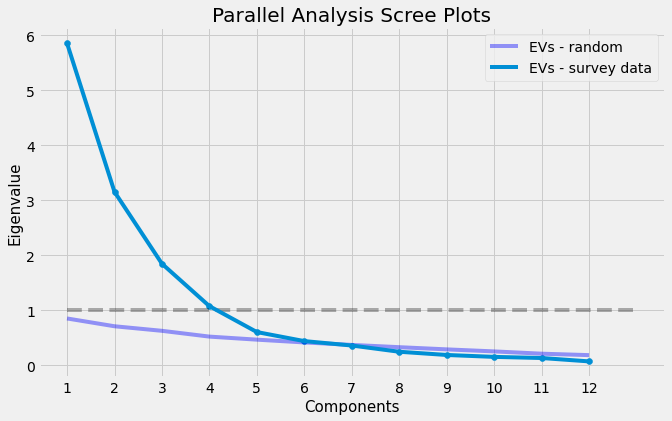

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.85
2	0.71				3.15
3	0.63				1.85
4	0.52				1.08
5	0.47				0.60
6	0.42				0.44
7	0.37				0.36
8	0.33				0.25
9	0.29				0.19
10	0.25				0.15
11	0.21				0.13
12	0.19				0.07
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.


Removed item ss_sty_9
Communality: 0.1981

Fitted solution #2



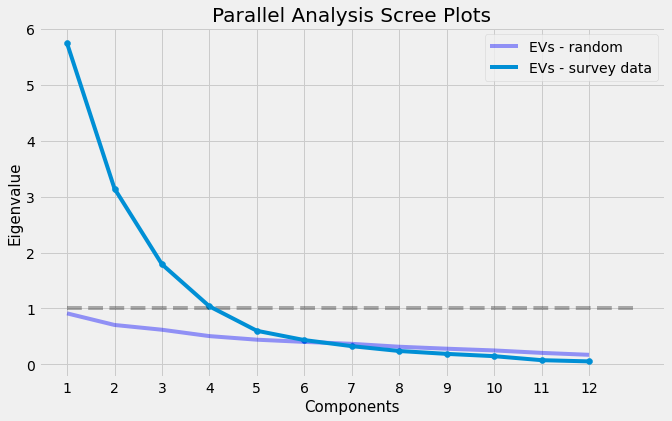

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.91				5.75
2	0.71				3.15
3	0.62				1.79
4	0.51				1.04
5	0.44				0.60
6	0.40				0.43
7	0.37				0.33
8	0.32				0.24
9	0.28				0.19
10	0.25				0.15
11	0.21				0.08
12	0.17				0.05
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 5 items with low main loading. Excluding them for next analysis.


Removed item ss_coh_9
Main (absolute) Loading: 0.3445


Removed item ss_conch_7
Main (absolute) Loading: 0.2800


Removed item ss_sty_3
Main (absolute) Loading: 0.3919


Removed item ss_sty_5
Main (absolute) Loading: 0.3750


Removed item ss_pac_7
Main (absolute) Loading: 0.3719

Fitted solution #3



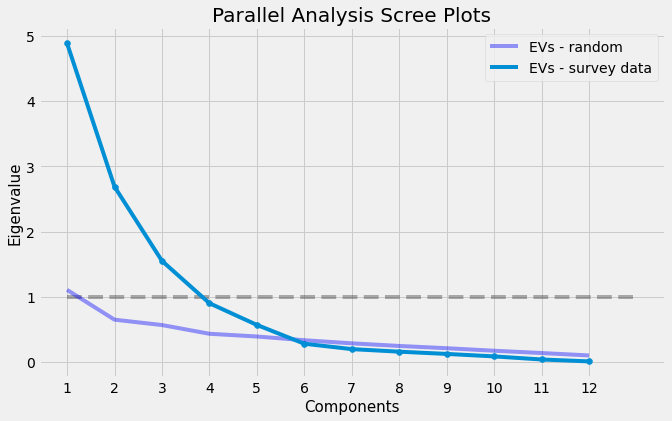

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.11				4.88
2	0.65				2.69
3	0.57				1.55
4	0.43				0.90
5	0.39				0.57
6	0.33				0.28
7	0.29				0.20
8	0.25				0.16
9	0.21				0.13
10	0.17				0.09
11	0.14				0.04
12	0.10				0.01
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 3 items with low main loading. Excluding them for next analysis.


Removed item ss_qua_2
Main (absolute) Loading: 0.3882


Removed item ss_sty_8
Main (absolute) Loading: 0.2954


Removed item ss_pac_6
Main (absolute) Loading: 0.3585

Fitted solution #4



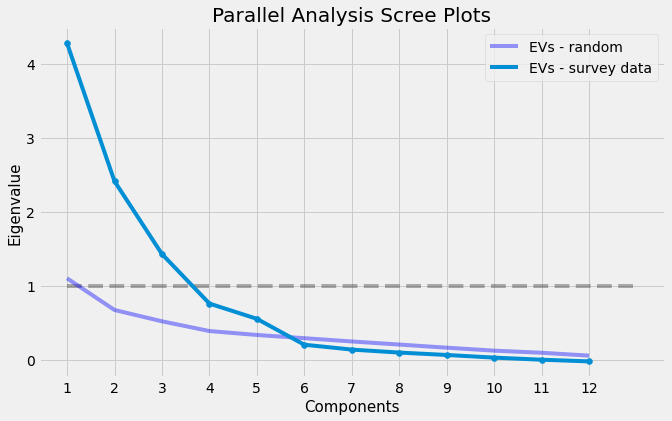

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				4.27
2	0.67				2.41
3	0.52				1.43
4	0.39				0.76
5	0.34				0.55
6	0.29				0.20
7	0.25				0.14
8	0.21				0.10
9	0.16				0.07
10	0.12				0.03
11	0.10				0.00
12	0.06				-0.02
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 3 items with high cross loading. Excluding them for next analysis.

Removed item ss_qua_7
Loadings: 
0    0.426806
1    0.450374
2   -0.130932
3    0.051130
4    0.024554
5    0.011470
Name: ss_qua_7, dtype: float64

Removed item ss_pac_1
Loadings: 
0   -0.139241
1    0.084150
2   -0.034217
3    0.104944
4   -0.288837
5    0.406268
Name: ss_pac_1, dtype: float64

Removed item ss_pac_9
Loadings: 
0    0.430603
1    0.107987
2   -0.104354
3 

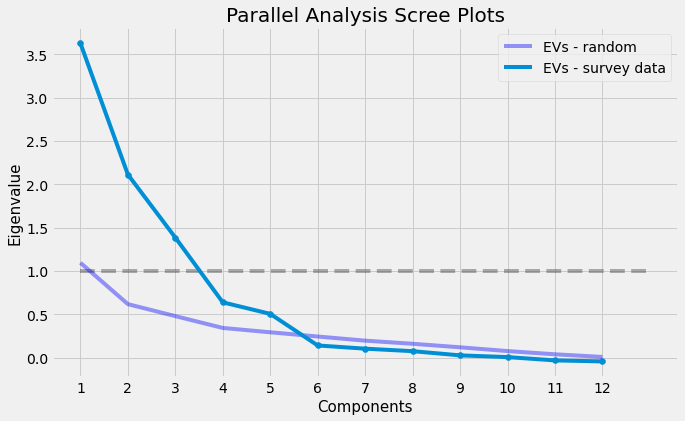

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				3.63
2	0.62				2.11
3	0.48				1.39
4	0.34				0.64
5	0.29				0.51
6	0.24				0.14
7	0.20				0.10
8	0.16				0.08
9	0.12				0.03
10	0.08				0.01
11	0.04				-0.03
12	0.01				-0.04
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.


Removed item ss_rep_10
Main (absolute) Loading: 0.3888

Fitted solution #6



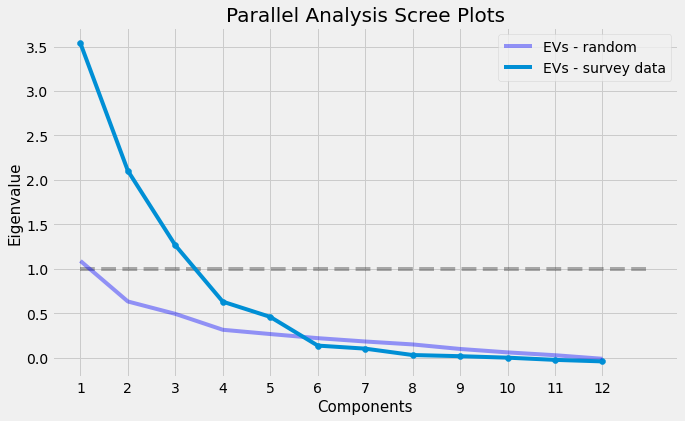

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				3.54
2	0.63				2.10
3	0.49				1.27
4	0.32				0.63
5	0.27				0.46
6	0.22				0.14
7	0.18				0.10
8	0.15				0.03
9	0.10				0.02
10	0.06				0.00
11	0.03				-0.02
12	-0.01				-0.04
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item ss_cre_12
Loadings: 
0   -0.025717
1   -0.032033
2   -0.065025
3    0.406160
4   -0.014533
5    0.354511
Name: ss_cre_12, dtype: float64

Fitted solution #7



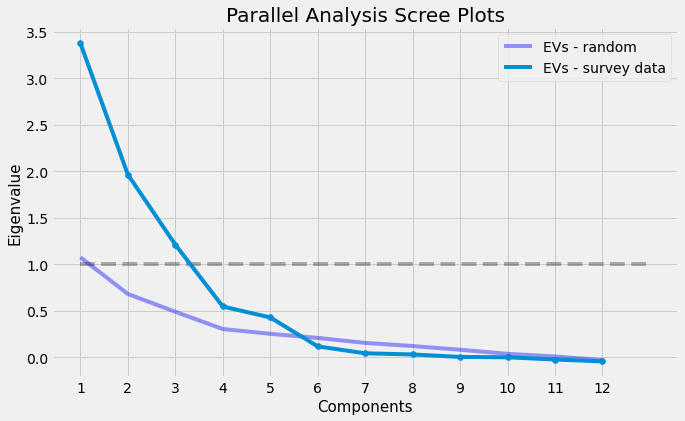

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.08				3.38
2	0.68				1.96
3	0.49				1.21
4	0.31				0.55
5	0.25				0.43
6	0.21				0.12
7	0.16				0.04
8	0.12				0.03
9	0.08				0.01
10	0.04				0.00
11	0.01				-0.02
12	-0.03				-0.04
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.00827380920983569
Determinant looks good!
Overall KMO: 0.7929921663168333
All item KMOs are >.6


In [101]:
six_facs = efa_utils.iterative_efa(aiss, items_analysis, n_facs=6, rotation_method="Oblimin", print_details=True,
                         print_par_plot=True, print_par_table=True, auto_stop_par=False, par_n_facs = 12)

The 6-factor solution looks fairly unstable. After sorting out items with low communality, low main loadings or high cross-loadings, the parallel analysis suggests 5 factors while the screeplot suggests 4 or 5. I am therefore a bit skeptical of the 6-factor solution, but I will take a closer look regardless.

##### Interpreting Factors
To interpret the meaning of the factors, I will have a look at the main loadings per factor

In [102]:
efa_6 = six_facs[0]
items_6 = six_facs[1]

efa_utils.print_sorted_loadings(efa_6, items_6, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                   0                                                                     descr
ss_pac_8    0.669460                      All elements of the story were relevant to the plot.
ss_coh_6    0.637741                                     The story felt like a coherent story.
ss_coh_11   0.614368                                              The story had a clear theme.
ss_coh_3    0.573848                                   The story appeared to be a single plot.
ss_conch_8  0.484983  It was easy to understand the motivation of the characters in the story. 

Relevant loadings for factor 1
                 1                                                                             descr
ss_rep_8  0.755928  One character did something he or she had already done previously in this story.
ss_rep_2  0.731998            Many sentences in the story had frequently repeated words and phrases.
ss_rep_1 -0.668244                                             

Given the 1 or 2 principal items per factor, I would interpret the factors as follows:

Factor # | Interpretation
---|---
0 | Coherence
1 | Repetitiveness
2 | Consistent Characterizations
3 | Surprise
4 | Pace
5 | Predictiveness

Factor 2 and 5 only have 2 or one item, which is a bit meager. But let's have a look at the internal consistency of the other factors first.

##### Internal Consistency Of Factors

In [103]:
# Create reversed items in the dataframe where necessary
# Also create a dictonary with a list of items per factor
aiss, items_per_fac_6 = efa_utils.rev_items_and_return(aiss, efa_6, items_6)

# Give out internal reliability estimates for factors
efa_utils.factor_int_reliability(aiss, items_per_fac_6)

Internal consistency for factor 0:
Cronbachs alpha = 0.7698, 95.0% CI = [0.73, 0.81]

Cronbach's alpha when excluding variable...
ss_coh_3: 0.7587
ss_coh_6: 0.6980
ss_coh_11: 0.7210
ss_conch_8: 0.7380
ss_pac_8: 0.7209


Internal consistency for factor 1:
Cronbachs alpha = 0.7640, 95.0% CI = [0.72, 0.81]

Cronbach's alpha when excluding variable...
ss_rep_2: 0.6804
ss_rep_8: 0.6729
ss_rep_1_rev: 0.6960


Internal consistency for factor 2:
Factor has only two items, will use Spearman-Brown instead.
Spearman-Brown reliability = 0.7637


Internal consistency for factor 3:
Cronbachs alpha = 0.6120, 95.0% CI = [0.53, 0.68]

Cronbach's alpha when excluding variable...
ss_cre_6: 0.4641
ss_cre_7: 0.3810
ss_cre_9: 0.6626


Internal consistency for factor 4:
Cronbachs alpha = 0.6609, 95.0% CI = [0.59, 0.72]

Cronbach's alpha when excluding variable...
ss_rep_7: 0.5573
ss_pac_3: 0.6640
ss_pac_5: 0.4564


Internal consistency for factor 5:
Factor has only one item, cannot compute reliability.




Factor 0 and 1 have acceptable internal consistency and 3+ items - looks fairly healthy.

The other factors either have less than 3 items or low internal consistency, so they might be a bit unstable.

With so many potential items, it is possible that the exclusion for multicollinearity was too strict. Now that we have more clearly defined factors, I will try to include items that seem to fit thematically, and repeat the whole process. That is, I will test if these items still should be excluded due to multicollinearity even in a smaller item pool and then run the iterative EFA again.

#### 2nd Iterative EFA For 6 Factor Solution

In [104]:
items_6_2 = copy.deepcopy(items_6)

# Add previously sorted out items due to multicollinearity back to the list of items for analysis
# Thematically fitting for factor 2 (Consistent Characterization)
# Also add items that concern general consistency, just in case
items_6_2.extend([
    "ss_coh_1", "ss_coh_8",
    "ss_conch_1", "ss_conch_3", "ss_conch_5", "ss_conch_6"
    ])
# For factor 3 (Surprise)
# also add items that concern creativity
items_6_2.extend([
    "ss_cre_1", "ss_cre_2", "ss_cre_4", "ss_cre_5", "ss_cre_8", "ss_cre_10", "ss_cre_11"
    ])
# For factor 4 (Pace)
items_6_2.extend(["ss_pac_2", "ss_pac_4"])

# For factor 5 (Predictiveness)
items_6_2.extend(["ss_coh_2", "ss_coh_4", "ss_coh_5", "ss_coh_10"])


In [105]:
items_6_2 = efa_utils.reduce_multicoll(aiss, items_6_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.646685040664891e-08

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item ss_coh_1. VIF: 21.61
('I had a hard time making sense of what was going on in the story.')

Excluded item ss_cre_5. VIF: 18.93
('The story was imaginative.')

Excluded item ss_conch_5. VIF: 18.75
('The descriptions of characters in the story were plausible.')

Excluded item ss_cre_2. VIF: 18.49
('The story was boring.')

Excluded item ss_coh_8. VIF: 17.46
('The story stayed on topic with a consistent plot.')

Excluded item ss_conch_3. VIF: 17.28
('My understanding of the characters in the story is unclear.')

Excluded item ss_conch_1. VIF: 16.68
('Descriptions of characters in the story were consistent.')

Excluded item ss_coh_10. VIF: 16.27
('The story had a clearly identifiable plot.')

Done! Determinant is now: 0.000015
I have excluded 8 redunant items with 28 items remaining


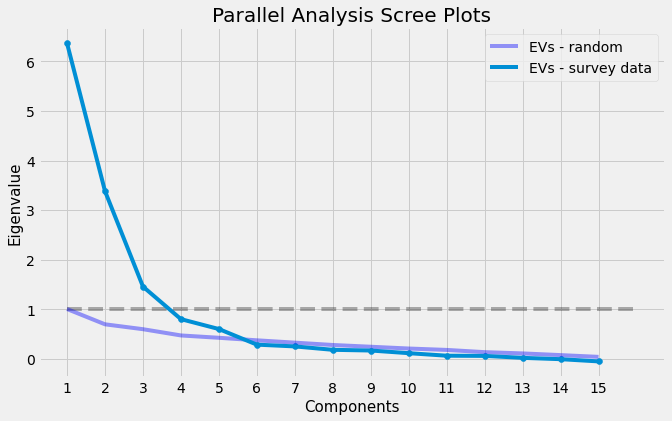

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.01				6.36
2	0.70				3.38
3	0.60				1.46
4	0.47				0.80
5	0.43				0.60
6	0.38				0.29
7	0.33				0.25
8	0.28				0.19
9	0.25				0.17
10	0.21				0.12
11	0.18				0.07
12	0.14				0.06
13	0.11				0.02
14	0.08				-0.00
15	0.04				-0.05
Suggested number of factors based on parallel analysis: 5


In [106]:
# Check new recommended number of factors
efa_utils.parallel_analysis(aiss, items_6_2, return_rec_n=False)

6 factors are questionable with the additional items (scree + parallel strongly suggests 5). Will run it anyway for the sake of completeness.

Fitted solution #1



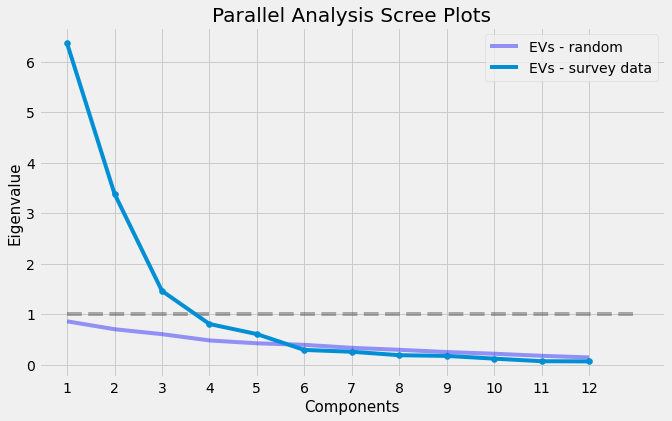

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.86				6.36
2	0.70				3.38
3	0.60				1.46
4	0.48				0.80
5	0.42				0.60
6	0.39				0.29
7	0.33				0.25
8	0.29				0.19
9	0.25				0.17
10	0.21				0.12
11	0.17				0.07
12	0.14				0.06
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.


Removed item ss_cre_6
Main (absolute) Loading: 0.3866


Removed item ss_cre_4
Main (absolute) Loading: 0.3956

Fitted solution #2



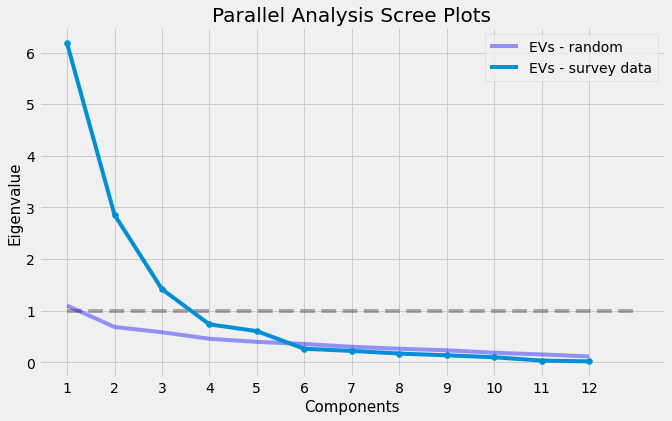

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				6.18
2	0.68				2.86
3	0.58				1.42
4	0.46				0.73
5	0.40				0.60
6	0.35				0.26
7	0.30				0.22
8	0.26				0.17
9	0.23				0.14
10	0.19				0.10
11	0.15				0.03
12	0.11				0.02
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 3 items with high cross loading. Excluding them for next analysis.

Removed item ss_cre_10
Loadings: 
0   -0.505663
1    0.268059
2    0.058485
3    0.085731
4   -0.016775
5    0.328032
Name: ss_cre_10, dtype: float64

Removed item ss_cre_11
Loadings: 
0    0.475845
1    0.178956
2    0.015255
3    0.069761
4   -0.053448
5   -0.321088
Name: ss_cre_11, dtype: float64

Removed item ss_pac_4
Loadings: 
0    0.012630
1   -0.062258
2    0.321394

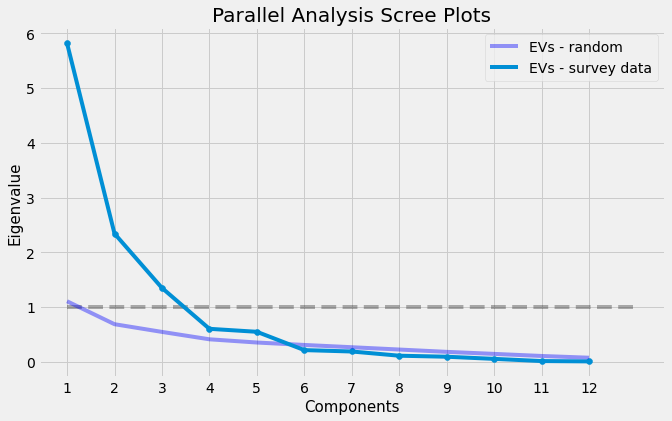

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				5.82
2	0.69				2.34
3	0.54				1.35
4	0.41				0.60
5	0.35				0.55
6	0.31				0.21
7	0.26				0.19
8	0.22				0.11
9	0.18				0.09
10	0.14				0.05
11	0.10				0.01
12	0.07				0.01
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.


Removed item ss_cre_9
Communality: 0.1776

Fitted solution #4



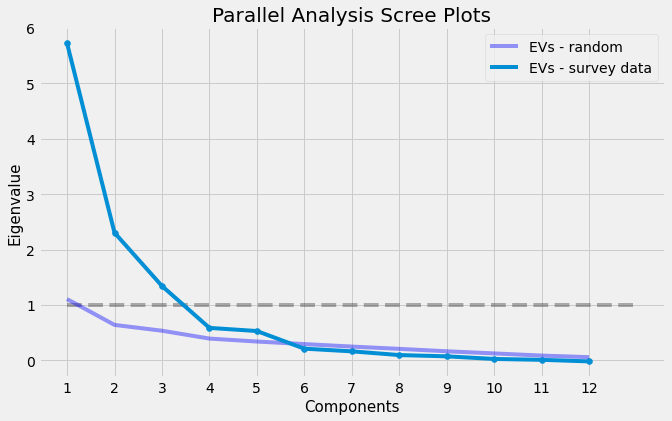

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.11				5.73
2	0.64				2.30
3	0.53				1.34
4	0.39				0.59
5	0.34				0.53
6	0.29				0.21
7	0.25				0.16
8	0.21				0.09
9	0.16				0.07
10	0.12				0.02
11	0.09				0.01
12	0.06				-0.02
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.00019805226787908742
Determinant looks good!
Overall KMO: 0.8783822552349095
All item KMOs are >.6


In [107]:
six_facs_2 = efa_utils.iterative_efa(aiss, items_6_2, n_facs=6, rotation_method="Oblimin", print_details=True,
                         print_par_plot=True, print_par_table=True, auto_stop_par=False, par_n_facs = 12)


In [108]:
# Interpreting revised 6 factors

efa_6_2 = six_facs_2[0]
items_6_2 = six_facs_2[1]

efa_utils.print_sorted_loadings(efa_6_2, items_6_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                   0                                                                     descr
ss_coh_11   0.638752                                              The story had a clear theme.
ss_coh_4    0.629133                                      The plot of the story was plausible.
ss_pac_8    0.623992                      All elements of the story were relevant to the plot.
ss_coh_3    0.606986                                   The story appeared to be a single plot.
ss_coh_2   -0.597084                    I had a hard time recognizing the thread of the story.
ss_coh_6    0.586089                                     The story felt like a coherent story.
ss_cre_3    0.558165                        The plot development in the story was predictable.
ss_coh_5    0.515321                         This story’s events occurred in a plausible order
ss_conch_8  0.510238  It was easy to understand the motivation of the characters in the story. 

Relevant loadings

Solution remains unstable: Factor 3 has only two item, factor 5 has only one.

Time to see if the other solutions perform better.

### 5 Factor Solution

#### Deciding on Factor Rotation


In [109]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=5, rotation='oblimin')
efa.fit(aiss[items_analysis])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)



Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.04297144 -0.26159701  0.16444447 -0.44826357]
 [ 0.04297144  1.          0.16393021 -0.248008    0.05531654]
 [-0.26159701  0.16393021  1.         -0.08402566  0.3011305 ]
 [ 0.16444447 -0.248008   -0.08402566  1.         -0.19306753]
 [-0.44826357  0.05531654  0.3011305  -0.19306753  1.        ]]


Again plenty of factors that are at least weakly correlated, and factor 1 and 5 are strongly correlated. I will therefore use oblique rotation.
#### Initial Iterative Factor Analysis

Fitted solution #1



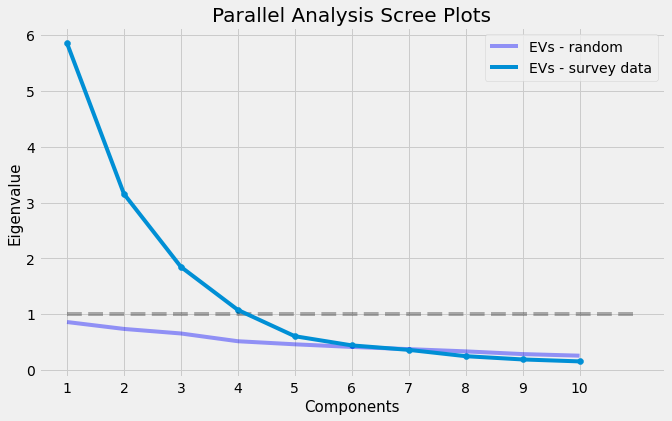

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 10 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.86				5.85
2	0.74				3.15
3	0.65				1.85
4	0.51				1.08
5	0.46				0.60
6	0.41				0.44
7	0.37				0.36
8	0.33				0.25
9	0.28				0.19
10	0.26				0.15
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 4 items with low main loading. Excluding them for next analysis.


Removed item ss_conch_7
Main (absolute) Loading: 0.3383


Removed item ss_cre_6
Main (absolute) Loading: 0.3843


Removed item ss_sty_3
Main (absolute) Loading: 0.3484


Removed item ss_pac_9
Main (absolute) Loading: 0.3261

Fitted solution #2



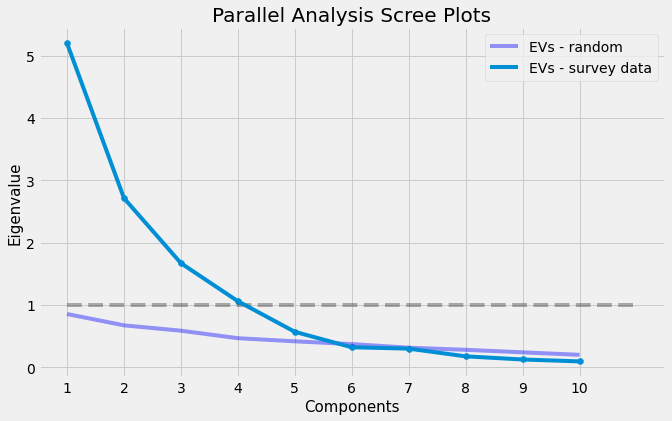

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 10 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.20
2	0.67				2.71
3	0.59				1.67
4	0.47				1.06
5	0.42				0.57
6	0.37				0.32
7	0.31				0.30
8	0.28				0.17
9	0.24				0.12
10	0.20				0.09
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.


Removed item ss_sty_8
Main (absolute) Loading: 0.3619

Fitted solution #3



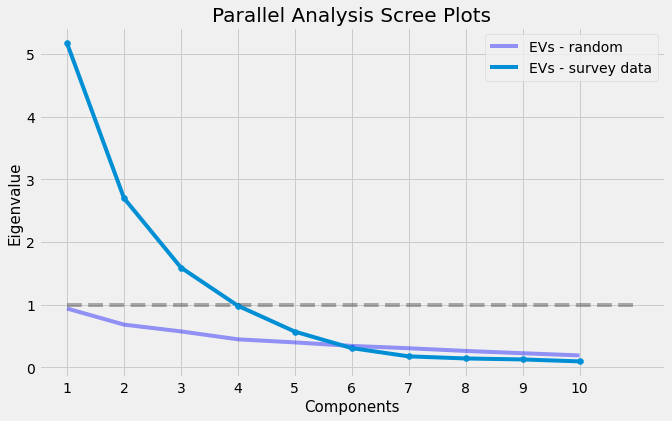

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 10 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.94				5.17
2	0.68				2.70
3	0.57				1.59
4	0.45				0.98
5	0.40				0.57
6	0.34				0.31
7	0.30				0.17
8	0.26				0.14
9	0.22				0.12
10	0.19				0.09
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 4 items with high cross loading. Excluding them for next analysis.

Removed item ss_coh_9
Loadings: 
0   -0.499351
1    0.075564
2    0.133584
3    0.317524
4    0.154046
Name: ss_coh_9, dtype: float64

Removed item ss_conch_8
Loadings: 
0    0.458301
1    0.272547
2    0.037351
3   -0.027379
4   -0.075563
Name: ss_conch_8, dtype: float64

Removed item ss_cre_7
Loadings: 
0   -0.022652
1    0.538126
2   -0.351052
3    0.048088
4    0.018012
Name: ss_cre_7, dtype: float64


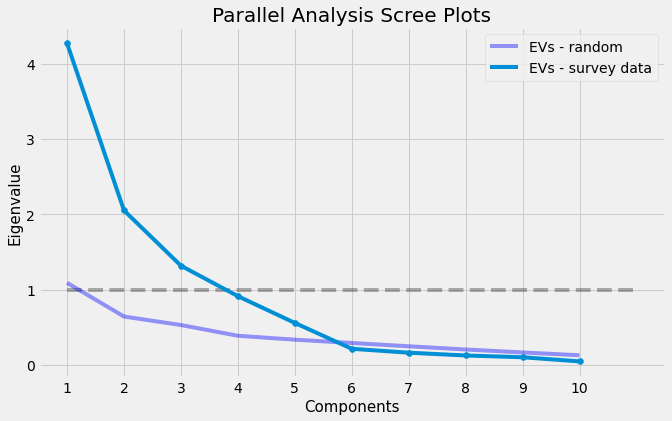

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 10 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				4.27
2	0.64				2.05
3	0.53				1.32
4	0.39				0.91
5	0.33				0.56
6	0.29				0.21
7	0.25				0.16
8	0.20				0.12
9	0.16				0.10
10	0.13				0.05
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0012862725179409176
Determinant looks good!
Overall KMO: 0.8170009472538168
All item KMOs are >.6


In [110]:
five_facs = efa_utils.iterative_efa(aiss, items_analysis, n_facs=5, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True, print_par_table=True, auto_stop_par=True, par_n_facs = 10)

5-Factor solution stays much more clearly defined than the 6-Factor after sorting out poorly fitting items.

##### Interpreting Factors

In [111]:
efa_5 = five_facs[0]
items_5 = five_facs[1]

efa_utils.print_sorted_loadings(efa_5, items_5, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                  0                                             descr
ss_cre_12  0.651997                         The story was innovative.
ss_qua_2   0.619499                    This story is of high quality.
ss_qua_7   0.590015  I would like to read more stories like this one.
ss_cre_9   0.551531            The setting of the story was original.
ss_sty_5   0.496377                The story used complex vocabulary.
ss_sty_9   0.475259       The story contained a great deal of detail. 

Relevant loadings for factor 1
                  1                                                     descr
ss_coh_3   0.633280                   The story appeared to be a single plot.
ss_coh_11  0.592223                              The story had a clear theme.
ss_cre_3   0.579381        The plot development in the story was predictable.
ss_pac_8   0.536419      All elements of the story were relevant to the plot.
ss_coh_6   0.493200                     The story felt l

Given the 1 or 2 principal items per factor, I would interpret the factors as follows:

Factor # | Interpretation
---|---
0 | Innovativeness & Quality
1 | Coherence
2 | Repetitiveness
3 | Pace
4 | Consistent Characterizations

Consistent Charecterization only has 2 items, which is not ideal. But also in this case, I will first look look at the internal consistency of the factors.

##### Internal Consistency Of Factors

In [112]:
# Create reversed items in the dataframe where necessary
# Also create a dictonary with a list of items per factor
aiss, items_per_fac_5 = efa_utils.rev_items_and_return(aiss, efa_5, items_5)

# Give out internal reliability estimates for factors
efa_utils.factor_int_reliability(aiss, items_per_fac_5)

Internal consistency for factor 0:
Cronbachs alpha = 0.7511, 95.0% CI = [0.71, 0.79]

Cronbach's alpha when excluding variable...
ss_cre_9: 0.7271
ss_cre_12: 0.7109
ss_qua_2: 0.6799
ss_qua_7: 0.6957
ss_sty_5: 0.7357
ss_sty_9: 0.7382


Internal consistency for factor 1:
Cronbachs alpha = 0.7632, 95.0% CI = [0.72, 0.80]

Cronbach's alpha when excluding variable...
ss_coh_3: 0.7168
ss_coh_6: 0.7060
ss_coh_11: 0.7198
ss_cre_3: 0.7459
ss_pac_8: 0.7301
ss_pac_7_rev: 0.7496


Internal consistency for factor 2:
Cronbachs alpha = 0.7453, 95.0% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
ss_rep_2: 0.6463
ss_rep_8: 0.6451
ss_rep_10: 0.7640
ss_rep_1_rev: 0.6779


Internal consistency for factor 3:
Cronbachs alpha = 0.6867, 95.0% CI = [0.63, 0.74]

Cronbach's alpha when excluding variable...
ss_rep_7: 0.6487
ss_pac_3: 0.5977
ss_pac_5: 0.5736
ss_pac_1_rev: 0.6609


Internal consistency for factor 4:
Factor has only two items, will use Spearman-Brown instead.
Spearman-Brown reliabi

Item _ss_rep_10_ seems to be not very consistent with the _Repetitiveness_ factor. I will exclude it for the next run.

Cronbach's alpha for _Pace_ is a bit on the low side (0.69).

_Consistent Characterizations_ has acceptable internal consistency, even if it only consists of 2 items. So this solution already would be acceptable in its current form. However, I would rather see 3+ items per factor to make sure it is stable and well-defined.

So for _Pace_ and _Consistent Characterizations_, I will include thematically fitting items that were intially excluded due to potential multicollinearity and run the iterative EFA again.

#### 2nd Iterative EFA For 5 Factor Solution

In [113]:
items_5_2 = copy.deepcopy(items_5)

items_5_2.remove("ss_rep_10")

## Add previously sorted out items due to multicollinearity back to the list of items for analysis
# Thematically fitting for factor 2 (Consistent Characterization)
# Also add items that concern general consistency, just in case
items_5_2.extend([
    "ss_coh_1", "ss_coh_8",
    "ss_conch_1", "ss_conch_3", "ss_conch_5", "ss_conch_6"
    ])

# For factor 4 (Pace)
items_5_2.extend(["ss_pac_2", "ss_pac_4"])


In [114]:
items_5_2 = efa_utils.reduce_multicoll(
    aiss, items_5_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 6.421131028558279e-06

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item ss_coh_1. VIF: 18.96
('I had a hard time making sense of what was going on in the story.')

Done! Determinant is now: 0.000016
I have excluded 1 redunant items with 28 items remaining


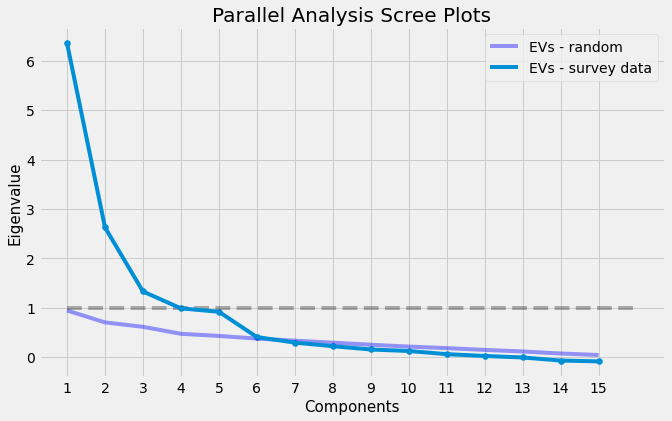

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.94				6.35
2	0.70				2.63
3	0.61				1.33
4	0.47				0.99
5	0.43				0.92
6	0.38				0.41
7	0.33				0.29
8	0.29				0.22
9	0.25				0.16
10	0.21				0.12
11	0.18				0.06
12	0.15				0.02
13	0.11				-0.01
14	0.07				-0.07
15	0.04				-0.09
Suggested number of factors based on parallel analysis: 6


In [115]:
# Check new recommended number of factors
efa_utils.parallel_analysis(aiss, items_5_2, return_rec_n=False)

With this set of items, I would usually extract either 6 (parallel analysis), 3 or 5 factors (screeplot). However, the goal of this process is to optimze the 5-factor solution, so I will stick with that.

(Also note that it is again fairly close for 6-factors, as the EV is barely higher than for random data)

Fitted solution #1



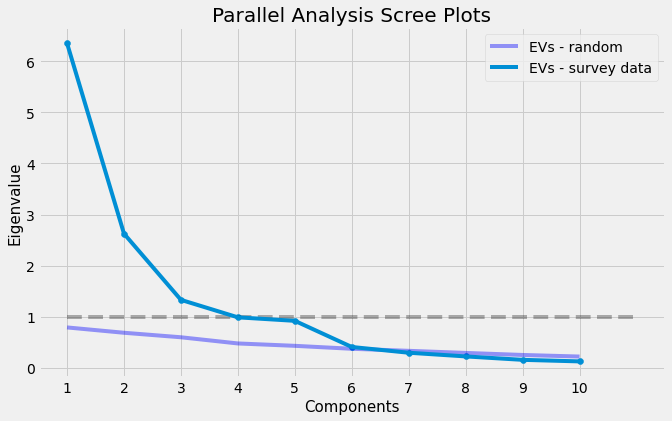


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.


Removed item ss_conch_3
Main (absolute) Loading: 0.3411

Fitted solution #2



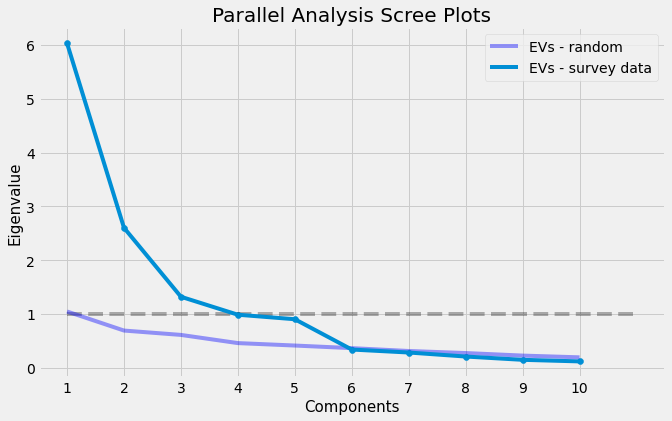


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item ss_pac_4
Loadings: 
0   -0.000378
1   -0.038082
2    0.118848
3    0.486724
4    0.323027
Name: ss_pac_4, dtype: float64

Fitted solution #3



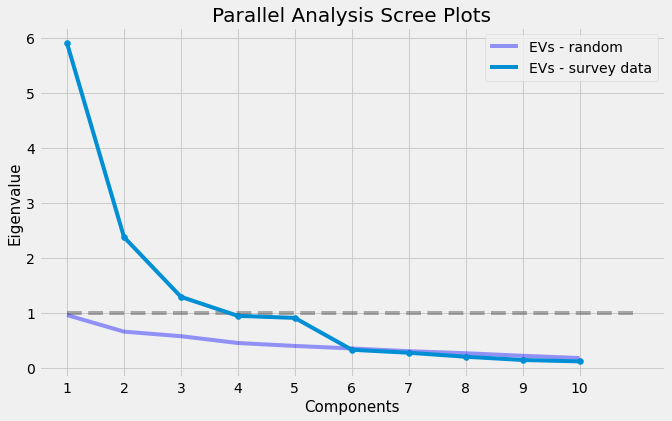


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 4.68500303250807e-05
Determinant looks good!
Overall KMO: 0.8524169088895661
All item KMOs are >.6


In [116]:
five_facs_2 = efa_utils.iterative_efa(aiss, items_5_2, n_facs=5, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True, auto_stop_par=True, par_n_facs = 10)


Most new items were retained. Time to have a look at the factors.

In [117]:
# Interpreting revised 5 factors
efa_5_2 = five_facs_2[0]
items_5_2 = five_facs_2[1]

efa_utils.print_sorted_loadings(efa_5_2, items_5_2, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                   0                                                              descr
ss_coh_8    0.765527                  The story stayed on topic with a consistent plot.
ss_coh_3    0.644744                            The story appeared to be a single plot.
ss_coh_11   0.612182                                       The story had a clear theme.
ss_cre_3    0.573650                 The plot development in the story was predictable.
ss_coh_6    0.513679                              The story felt like a coherent story.
ss_pac_8    0.495539               All elements of the story were relevant to the plot.
ss_conch_6 -0.485877  The behavior of characters in the story seemed completely random.
ss_pac_7   -0.483658           Many things seemed to be happening at once in the story. 

Relevant loadings for factor 1
                  1                                             descr
ss_qua_7   0.671949  I would like to read more stories like this one.
ss_c

Some of the new items were added on to the Coherence factor, some where added to the _Consistent Characterization_ factor.

The factors should therefore now be a bit better defined.

Order of the factors has changed slightly, but the interpretation remains the same.

Factor # | Interpretation
---|---
0 | Coherence
1 | Quality & Innovativeness
2 | Consistent Characterizations
3 | Pace
4 | Repetitiveness

In [118]:
# Create reversed items in the dataframe where necessary
# Also create a dictonary with a list of items per factor
aiss, items_per_fac_5_2 = efa_utils.rev_items_and_return(aiss, efa_5_2, items_5_2)

# Give out internal reliability estimates for factors
efa_utils.factor_int_reliability(aiss, items_per_fac_5_2)

Internal consistency for factor 0:
Cronbachs alpha = 0.8359, 95.0% CI = [0.81, 0.86]

Cronbach's alpha when excluding variable...
ss_coh_3: 0.8166
ss_coh_6: 0.8044
ss_coh_11: 0.8139
ss_cre_3: 0.8294
ss_pac_8: 0.8226
ss_coh_8: 0.7959
ss_pac_7_rev: 0.8300
ss_conch_6_rev: 0.8176


Internal consistency for factor 1:
Cronbachs alpha = 0.7962, 95.0% CI = [0.76, 0.83]

Cronbach's alpha when excluding variable...
ss_cre_9: 0.7859
ss_cre_12: 0.7675
ss_qua_2: 0.7458
ss_qua_7: 0.7477
ss_sty_5: 0.7922
ss_sty_9: 0.7934
ss_pac_2: 0.7511


Internal consistency for factor 2:
Cronbachs alpha = 0.8022, 95.0% CI = [0.76, 0.83]

Cronbach's alpha when excluding variable...
ss_conch_2: 0.7557
ss_conch_4: 0.7037
ss_conch_1_rev: 0.7317
ss_conch_5_rev: 0.8074


Internal consistency for factor 3:
Cronbachs alpha = 0.6867, 95.0% CI = [0.63, 0.74]

Cronbach's alpha when excluding variable...
ss_rep_7: 0.6487
ss_pac_3: 0.5977
ss_pac_5: 0.5736
ss_pac_1_rev: 0.6609


Internal consistency for factor 4:
Cronbachs alph

_Mostly_ fairly consistent scales. 

Scale | Cronbach's α
---|---
Coherence | .84
Quality &Innovativeness | .80
Consistent Characterizations | .80
Pace | .69
Repetitiveness | .76

`ss_conch_5_rev` does not show the strongest correlation to the _Consistent Characterization_ scale as a whole, and I might take it out in future revisions of the scale (reversed score for _"The descriptions of characters in the story were plausible."_) For now, I will leave it in though, as it is fairly inconclusive.

Internal consistency for _Pace_ could not be improved. This scale will have to be improved upon in future revisions.

In summary, the 5-factor solution is stable and well-defined. Let us have a look at the 4-factor solution to see if it does better.

### 4 Factor Solution

#### Deciding on Factor Rotation

In [119]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(aiss[items_analysis])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)



Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.01330833 -0.30122289  0.1938823 ]
 [ 0.01330833  1.          0.16913105 -0.24236404]
 [-0.30122289  0.16913105  1.         -0.08327231]
 [ 0.1938823  -0.24236404 -0.08327231  1.        ]]


With factor 1 and 3 correlating with r = -.30, I will use oblique rotation.

#### Initial Iterative Factor Analysis

Fitted solution #1



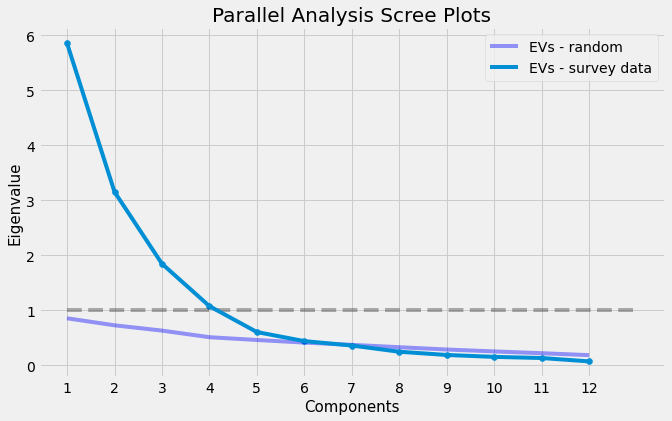

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.85
2	0.73				3.15
3	0.63				1.85
4	0.51				1.08
5	0.46				0.60
6	0.41				0.44
7	0.37				0.36
8	0.33				0.25
9	0.29				0.19
10	0.25				0.15
11	0.22				0.13
12	0.18				0.07
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.


Removed item ss_conch_2
Communality: 0.1903

Fitted solution #2



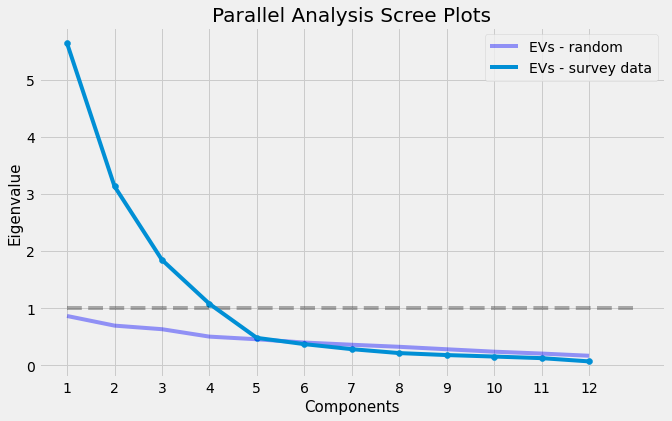

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.86				5.64
2	0.70				3.14
3	0.63				1.85
4	0.50				1.08
5	0.46				0.48
6	0.40				0.37
7	0.36				0.28
8	0.32				0.21
9	0.28				0.18
10	0.24				0.15
11	0.21				0.13
12	0.17				0.07
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.


Removed item ss_conch_4
Communality: 0.1781

Fitted solution #3



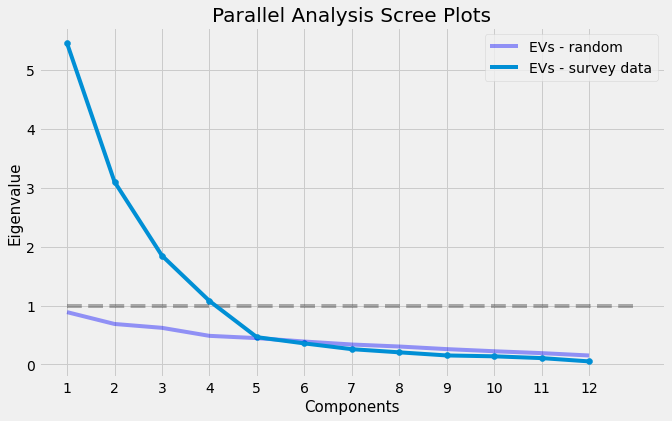

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.89				5.45
2	0.69				3.10
3	0.62				1.85
4	0.49				1.08
5	0.45				0.46
6	0.39				0.36
7	0.34				0.26
8	0.31				0.21
9	0.26				0.15
10	0.22				0.14
11	0.19				0.11
12	0.15				0.05
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 4 items with low main loading. Excluding them for next analysis.


Removed item ss_cre_6
Main (absolute) Loading: 0.3763


Removed item ss_sty_3
Main (absolute) Loading: 0.3457


Removed item ss_sty_8
Main (absolute) Loading: 0.3991


Removed item ss_pac_9
Main (absolute) Loading: 0.3348

Fitted solution #4



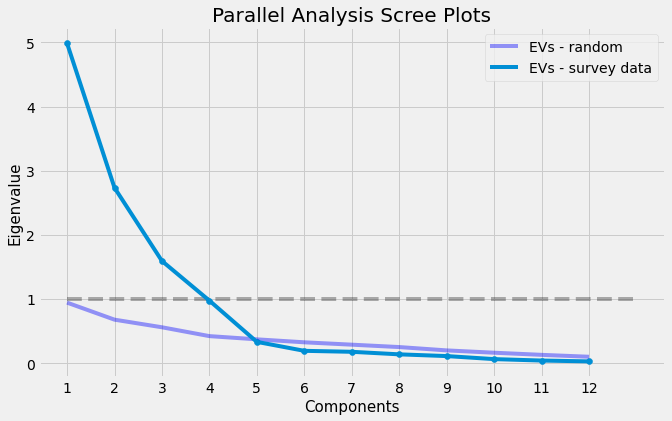

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.95				4.99
2	0.68				2.74
3	0.56				1.59
4	0.42				0.98
5	0.37				0.33
6	0.33				0.19
7	0.29				0.18
8	0.25				0.14
9	0.20				0.11
10	0.17				0.07
11	0.13				0.04
12	0.10				0.03
Suggested number of factors based on parallel analysis: 4

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 4 items with high cross loading. Excluding them for next analysis.

Removed item ss_coh_9
Loadings: 
0   -0.580127
1    0.078792
2    0.140388
3    0.321051
Name: ss_coh_9, dtype: float64

Removed item ss_cre_7
Loadings: 
0   -0.038037
1    0.545254
2   -0.344527
3    0.053995
Name: ss_cre_7, dtype: float64

Removed item ss_rep_7
Loadings: 
0   -0.309206
1   -0.115355
2    0.516784
3    0.054797
Name: ss_rep_7, dtype: float64

Removed item 

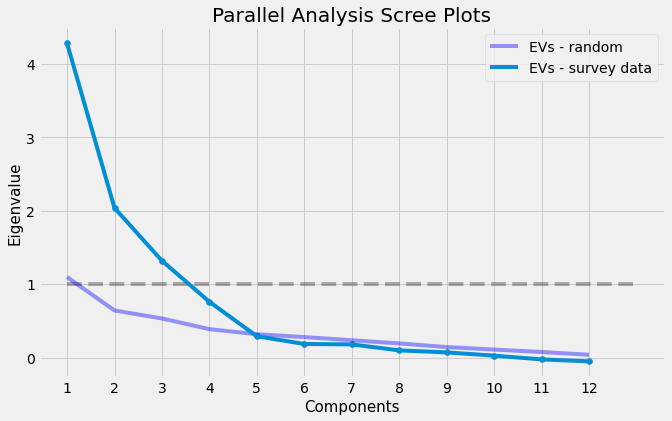

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 12 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				4.28
2	0.64				2.04
3	0.53				1.32
4	0.39				0.76
5	0.32				0.29
6	0.28				0.19
7	0.24				0.18
8	0.19				0.10
9	0.14				0.07
10	0.11				0.03
11	0.08				-0.02
12	0.04				-0.05
Suggested number of factors based on parallel analysis: 4

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0021986121784470297
Determinant looks good!
Overall KMO: 0.8415597764816954
All item KMOs are >.6


In [120]:
four_facs = efa_utils.iterative_efa(aiss, items_analysis, n_facs=4, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True, print_par_table=True, auto_stop_par=True, par_n_facs = 12)


##### Interpreting Factors

In [121]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

efa_utils.print_sorted_loadings(efa_4, items_4, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                   0                                                                     descr
ss_coh_3    0.645044                                   The story appeared to be a single plot.
ss_coh_11   0.627631                                              The story had a clear theme.
ss_coh_6    0.619259                                     The story felt like a coherent story.
ss_pac_8    0.619116                      All elements of the story were relevant to the plot.
ss_pac_7   -0.543949                  Many things seemed to be happening at once in the story.
ss_cre_3    0.530843                        The plot development in the story was predictable.
ss_conch_8  0.509737  It was easy to understand the motivation of the characters in the story.
ss_conch_7 -0.439239                     How characters in the story acted seemed implausible. 

Relevant loadings for factor 1
                  1                                             descr
ss_cre_12  

Interpretation of the factors according to principal items is as follows:

Factor # | Interpretation
---|---
0 | Coherence
1 | Innovativeness & Quality
2 | Repetitiveness
3 | Pace

In [122]:
# Create reversed items in the dataframe where necessary
# Also create a dictonary with a list of items per factor
aiss, items_per_fac_4 = efa_utils.rev_items_and_return(aiss, efa_4, items_4)

# Give out internal reliability estimates for factors
efa_utils.factor_int_reliability(aiss, items_per_fac_4)

Internal consistency for factor 0:
Cronbachs alpha = 0.8052, 95.0% CI = [0.77, 0.84]

Cronbach's alpha when excluding variable...
ss_coh_3: 0.7810
ss_coh_6: 0.7637
ss_coh_11: 0.7783
ss_conch_8: 0.7813
ss_cre_3: 0.7926
ss_pac_8: 0.7836
ss_conch_7_rev: 0.7906
ss_pac_7_rev: 0.7938


Internal consistency for factor 1:
Cronbachs alpha = 0.7511, 95.0% CI = [0.71, 0.79]

Cronbach's alpha when excluding variable...
ss_cre_9: 0.7271
ss_cre_12: 0.7109
ss_qua_2: 0.6799
ss_qua_7: 0.6957
ss_sty_5: 0.7357
ss_sty_9: 0.7382


Internal consistency for factor 2:
Cronbachs alpha = 0.7453, 95.0% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
ss_rep_2: 0.6463
ss_rep_8: 0.6451
ss_rep_10: 0.7640
ss_rep_1_rev: 0.6779


Internal consistency for factor 3:
Cronbachs alpha = 0.6487, 95.0% CI = [0.58, 0.71]

Cronbach's alpha when excluding variable...
ss_pac_3: 0.4764
ss_pac_5: 0.6164
ss_pac_1_rev: 0.5573




##### Internal Consistency Of Factors

Item _ss_rep_10_ seems to be not very consistent with the _Repetitiveness_ factor. I will exclude it for the next run.

Factor 3 (Pace) has suboptimal internal consistency (Cronbach's alpha = 0.65). Again, I will include items that were initially excluded due to multicollinearity and run the iterative EFA again.

#### 2nd Iterative EFA For 5 Factor Solution

In [137]:
items_4_2 = copy.deepcopy(items_4)

items_4_2.remove("ss_rep_10")

# For factor 4 (Pace)
items_4_2.extend(["ss_pac_2", "ss_pac_4"])


In [138]:
items_4_2 = efa_utils.reduce_multicoll(
    aiss, items_4_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 0.0007243233197787315

Determinant is > 1e-05. No issues with multicollinearity detected.


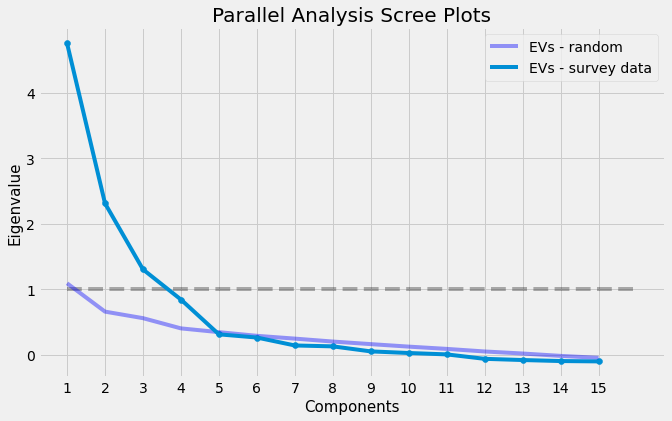

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				4.76
2	0.66				2.31
3	0.56				1.30
4	0.40				0.84
5	0.35				0.31
6	0.29				0.26
7	0.25				0.14
8	0.20				0.13
9	0.16				0.05
10	0.12				0.03
11	0.09				0.01
12	0.05				-0.06
13	0.02				-0.08
14	-0.02				-0.10
15	-0.05				-0.10
Suggested number of factors based on parallel analysis: 4


In [139]:
# Check new recommended number of factors
efa_utils.parallel_analysis(aiss, items_4_2, return_rec_n=False)

With this set of items, 4 factors are clearly the best solution.

Fitted solution #1



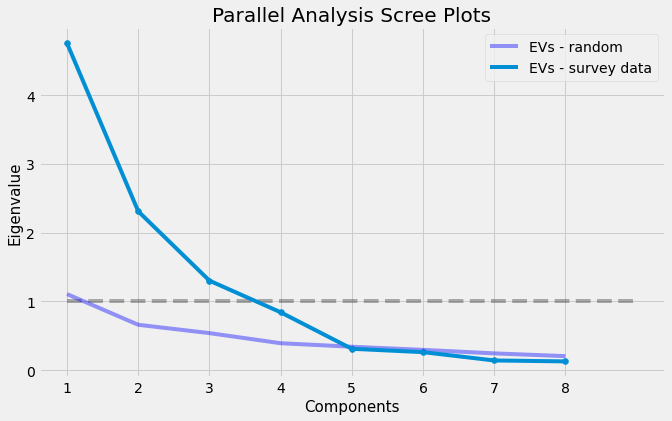


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item ss_pac_4
Loadings: 
0   -0.067065
1   -0.079299
2    0.352033
3    0.480193
Name: ss_pac_4, dtype: float64

Fitted solution #2



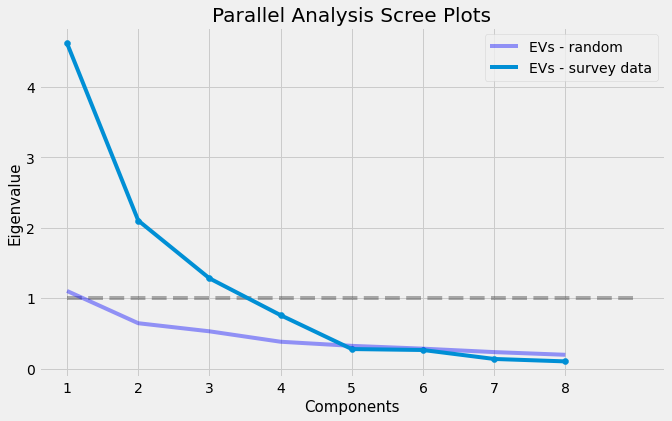


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0012082606745799083
Determinant looks good!
Overall KMO: 0.851621184956926
All item KMOs are >.6


In [140]:
four_facs_2 = efa_utils.iterative_efa(aiss, items_4_2, n_facs=4, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True, auto_stop_par=True, par_n_facs = 8)


In [141]:
efa_4_2 = four_facs_2[0]
items_4_2 = four_facs_2[1]

efa_utils.print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                  0                                             descr
ss_cre_12  0.699487                         The story was innovative.
ss_pac_2   0.652128                   The story was exciting to read.
ss_qua_2   0.645237                    This story is of high quality.
ss_qua_7   0.630295  I would like to read more stories like this one.
ss_cre_9   0.557362            The setting of the story was original.
ss_sty_5   0.469410                The story used complex vocabulary.
ss_sty_9   0.461581       The story contained a great deal of detail. 

Relevant loadings for factor 1
                   1                                                                     descr
ss_coh_3    0.648031                                   The story appeared to be a single plot.
ss_coh_11   0.615536                                              The story had a clear theme.
ss_coh_6    0.589410                                     The story felt like a coherent sto

_ss_pac_2_ was retained, but added to the _Innovativeness & Quality_ factor. So again pace could not really be improved here.

Order of the factors has changed slightly, but the interpretation remains the same.

Factor # | Interpretation
---|---
0 | Innovativeness & Quality
1 | Coherence
2 | Repetitiveness
3 | Pace

In [142]:
# Create reversed items in the dataframe where necessary
# Also create a dictonary with a list of items per factor
aiss, items_per_fac_4_2 = efa_utils.rev_items_and_return(aiss, efa_4_2, items_4_2)

# Give out internal reliability estimates for factors
efa_utils.factor_int_reliability(aiss, items_per_fac_4_2)

Internal consistency for factor 0:
Cronbachs alpha = 0.7962, 95.0% CI = [0.76, 0.83]

Cronbach's alpha when excluding variable...
ss_cre_9: 0.7859
ss_cre_12: 0.7675
ss_qua_2: 0.7458
ss_qua_7: 0.7477
ss_sty_5: 0.7922
ss_sty_9: 0.7934
ss_pac_2: 0.7511


Internal consistency for factor 1:
Cronbachs alpha = 0.8052, 95.0% CI = [0.77, 0.84]

Cronbach's alpha when excluding variable...
ss_coh_3: 0.7810
ss_coh_6: 0.7637
ss_coh_11: 0.7783
ss_conch_8: 0.7813
ss_cre_3: 0.7926
ss_pac_8: 0.7836
ss_conch_7_rev: 0.7906
ss_pac_7_rev: 0.7938


Internal consistency for factor 2:
Cronbachs alpha = 0.7640, 95.0% CI = [0.72, 0.81]

Cronbach's alpha when excluding variable...
ss_rep_2: 0.6804
ss_rep_8: 0.6729
ss_rep_1_rev: 0.6960


Internal consistency for factor 3:
Cronbachs alpha = 0.6487, 95.0% CI = [0.58, 0.71]

Cronbach's alpha when excluding variable...
ss_pac_3: 0.4764
ss_pac_5: 0.6164
ss_pac_1_rev: 0.5573




Final internal consistency for 4-factor solution.

Scale | Cronbach's α
---|---
Quality &Innovativeness | .80
Coherence | .81
Repetitiveness | .76
Pace | .65

First three factors show good to accetpable reliability.

Pace still has questionable reliablity.

Overall, this solution is mostly also stable and well-defined. The main difference to the 5-factor solution is the inclusion of a "Consistent Characterization" factor.

Both solutions seem fine, but I will go with the maximum number of well-defined and interpretable factors, which is 5.

# Examine Scale Scores


In [143]:
items_per_fac_5_2


{0: ['ss_coh_3',
  'ss_coh_6',
  'ss_coh_11',
  'ss_cre_3',
  'ss_pac_8',
  'ss_coh_8',
  'ss_pac_7_rev',
  'ss_conch_6_rev'],
 1: ['ss_cre_9',
  'ss_cre_12',
  'ss_qua_2',
  'ss_qua_7',
  'ss_sty_5',
  'ss_sty_9',
  'ss_pac_2'],
 2: ['ss_conch_2', 'ss_conch_4', 'ss_conch_1_rev', 'ss_conch_5_rev'],
 3: ['ss_rep_7', 'ss_pac_3', 'ss_pac_5', 'ss_pac_1_rev'],
 4: ['ss_rep_2', 'ss_rep_8', 'ss_rep_1_rev']}

In [ ]:
# The following code could be used to get mean scale scores
# Gave preference to factor scores instead (see below)

# # compute scale means but only if at least 66% of questions are answered
# mask_suff_data_coh = aiss[items_per_fac_5_2[0]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[0])/3)
# mask_suff_data_cre = aiss[items_per_fac_5_2[1]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[1])/3)
# mask_suff_data_conch = aiss[items_per_fac_5_2[2]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[2])/3)
# mask_suff_data_pac = aiss[items_per_fac_5_2[3]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[3])/3)
# mask_suff_data_rep = aiss[items_per_fac_5_2[4]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[4])/3)

# aiss["tss_coh"] = aiss[mask_suff_data_coh][items_per_fac_5_2[0]].mean(
#     axis=1)
# aiss["tss_cre"] = aiss[mask_suff_data_cre][items_per_fac_5_2[1]].mean(
#     axis=1)
# aiss["tss_conch"] = aiss[mask_suff_data_cre][items_per_fac_5_2[2]].mean(
#     axis=1)
# aiss["tss_pac"] = aiss[mask_suff_data_pac][items_per_fac_5_2[3]].mean(
#     axis=1)
# aiss["tss_rep"] = aiss[mask_suff_data_rep][items_per_fac_5_2[4]].mean(
#     axis=1)


# For oblique rotation with FactorAnalyzer the order of factors in the rotated loadings
# and order of factor of factor scores obtained with transform() can be different
# (and is in this case)
# see https://stackoverflow.com/questions/59284044/factor-order-differs-between-loadings-and-scoring-with-oblimin-rotation-how-i
# Therefore: Transform first, then figure out order of factors with correlation
aiss[["tss_fac1", "tss_fac2", "tss_fac3", "tss_fac4", "tss_fac5"]
       ] = efa_5_2.transform(aiss[items_5_2])

aiss[["tss_fac1", "tss_fac2", "tss_fac3", "tss_fac4", "tss_fac5",
        "tss_coh_3", "tss_cre_9", "tss_conch_4", "tss_pac_3", "tss_rep_3"]].corr()


In [ ]:
# Rename factors
aiss.rename(columns={"tss_fac1": "tss_coh", "tss_fac2": "tss_pac",
                       "tss_fac3": "tss_rep", "tss_fac4": "tss_conch", "tss_fac5": "tss_cre"},
              inplace=True)

# Some factor scores might make more sense reversed
aiss["tss_pac"] = aiss["tss_pac"]*-1
aiss["tss_conch"] = aiss["tss_conch"]*-1
aiss["tss_avoid_rep"] = aiss["tss_rep"]*-1

# Standardize scores
# aiss[["tss_coh", "tss_cre", "tss_conch", "tss_pac", "tss_avoid_rep"]] = aiss[[
#     "tss_coh", "tss_cre", "tss_conch", "tss_pac", "tss_avoid_rep"]].apply(stats.zscore)


In [ ]:
# Check score distributions
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Histograms with KDE
ax1 = aiss["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
aiss["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = aiss["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
aiss["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = aiss["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
aiss["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")

ax4 = aiss["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
aiss["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")

ax5 = aiss["tss_conch"].plot.hist(ax=axes[4, 0], bins=12)
aiss["tss_conch"].plot.kde(ax=axes[4, 0], secondary_y=True)
ax5.set_xlabel("Consistent Characters")

# Q-Q Plots
stats.probplot(aiss["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(aiss["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(aiss["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(aiss["tss_avoid_rep"], dist="norm", plot=axes[3, 1])
stats.probplot(aiss["tss_conch"], dist="norm", plot=axes[4, 1])

# Boxplots
aiss["tss_coh"].plot.box(ax=axes[0, 2])
aiss["tss_cre"].plot.box(ax=axes[1, 2])
aiss["tss_pac"].plot.box(ax=axes[2, 2])
aiss["tss_avoid_rep"].plot.box(ax=axes[3, 2])
aiss["tss_conch"].plot.box(ax=axes[4, 2])

fig.tight_layout()
plt.show()


# Analyze Impact of Preset & Prompt


In [ ]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "prompt_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.show()


In [ ]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "preset_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.show()


## Use Word Count as a Control Variable?


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=aiss, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=aiss, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=aiss, y="tss_pac",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=aiss, y="tss_cre",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=aiss, y="tss_conch",
            x="word_count", lowess=True, ax=axes[4])


In [ ]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
aiss["words_cent"] = aiss["word_count"].apply(
    lambda x: x-aiss["word_count"].mean())  # centering

aiss["words_cent**2"] = aiss["words_cent"]*aiss["words_cent"]
aiss["words_cent**3"] = aiss["words_cent"]**3
#aiss["words_cent**4"] = aiss["words_cent"]**4
#aiss["words_cent**5"] = aiss["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]


for outcome in outcome_li:
    y = aiss[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = aiss.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA


## ANOVA Model Diagnostics


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="tss_coh", data=aiss, ax=axes[0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="preset_label", y="tss_pac", data=aiss, ax=axes[2])
sns.boxplot(x="preset_label", y="tss_cre", data=aiss, ax=axes[3])
sns.boxplot(x="preset_label", y="tss_conch", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=aiss, ax=axes[0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="prompt_label", y="tss_pac", data=aiss, ax=axes[2])
sns.boxplot(x="prompt_label", y="tss_cre", data=aiss, ax=axes[3])
sns.boxplot(x="prompt_label", y="tss_conch", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


In [ ]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")


In [ ]:
# Outliers for Presets

# Outliers Coherence
print("Exterme outliers on tss_coh, Basic Coherence preset")
determine_outliers(aiss[aiss["preset_label"] ==
                          "Basic Coherence"], "tss_coh")

# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(aiss[aiss["preset_label"] ==
                          "Morpho"], "tss_avoid_rep")

# Outliers pace
print("\nExterme outliers on tss_pac, Ace of Spade preset")
determine_outliers(aiss[aiss["preset_label"] == "Ace of Spade"], "tss_pac")

# Outliers creativity
print("\nExterme outliers on tss_cre, Ouroboros preset")
determine_outliers(aiss[aiss["preset_label"] == "Ouroboros"], "tss_cre")

# Outliers consistent characterization
print("\nExterme outliers on tss_pac, Ouroboros")
determine_outliers(aiss[aiss["preset_label"] ==
                          "Ouroboros"], "tss_conch")

# Outliers for Prompts

# Pace
print("\nExterme outliers on tss_avoid rep, Horror prompt")
determine_outliers(aiss[aiss["prompt_label"] == "Horror"], "tss_avoid_rep")

# Creativity
print("\nExterme outliers on tss_cre, Horror prompt")
determine_outliers(aiss[aiss["prompt_label"] == "Horror"], "tss_cre")


In [ ]:
#tss_no_out = aiss[~(aiss.index == 7)].copy()
tss_no_out = aiss


In [ ]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(groups_li), len(vars_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(vars_li)-1):
            x += 1
        else:
            x = 0
            y += 1


In [ ]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(20, 30))


In [ ]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 15))


In [ ]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {:.2f}, coefficient of sample size variation is {:.2f}, variance ratio is {:.2f}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")


In [ ]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")


## Running the ANOVA


In [ ]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]


In [ ]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept", "Panel"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # no adjustement for p necessary for sample source
    params_df.loc["Panel", outcome +
                  " adj_p"] = params_df.loc["Panel", outcome + " p-value"]
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]


In [ ]:
params_df


In [ ]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis=1)

params_df[mask_sig]


In [ ]:
tss_no_out["preset_label"].value_counts()


In [ ]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")


## Visualizing the Results


In [ ]:
labels = ["Coherence", "Creativity",
          "Avoiding Repitition", "Pace", "Consistent Characters"]
presets_1 = ["Genesis", "Ouroboros",
             "Basic Coherence", "Low Rider", "All-Nighter"]
presets_2 = ["Morpho", "Ace of Spade", "Fandango"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(-1, 1))
fig.text(0.02, 0.5, "Marginal Means (Community Sample)",
         va='center', rotation='vertical', fontsize=16)

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    # values are centered around the mean for the community sample (!)
    # so a value of 0 is exactly the expected mean for the community sample
    marginal_means_dict = {outcome: [] for outcome in outcome_li}
    yerr_dict = {outcome: [] for outcome in outcome_li}

    prod_presets_outcomes = itertools.product(pre_li, outcome_li)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(params_df.loc[preset, outcome])
        yerr_dict[outcome].append(
            params_df.loc[preset, outcome + " 90% CI margin"])

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcome_li:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(x-0.3, marginal_means_dict["tss_coh"], width,
               yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

    cur_ax.bar(x-0.15, marginal_means_dict["tss_cre"], width,
               yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

    cur_ax.bar(x, marginal_means_dict["tss_avoid_rep"], width,
               yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

    cur_ax.bar(x+0.15, marginal_means_dict["tss_pac"], width,
               yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

    cur_ax.bar(x+0.3, marginal_means_dict["tss_conch"], width,
               yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

    cur_ax.grid(False)

    i += 1

axes[0].legend(frameon=False, fontsize=16, loc='upper center',
               ncol=3, bbox_to_anchor=(0.6, 1))

# fig.tight_layout()
plt.show()

fig.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")


In [ ]:
# graph for Community vs Panel

# create dicts with a key for pe sample source with an empty list as value for each
marginal_means_dict = {"Community": [], "Panel": []}
yerr_dict = {"Community": [], "Panel": []}

outcome_labels = ["Coherence", "Creativity",
                  "Avoiding\nRepetition", "Pace", "Consistent\nCharacterization"]

for outcome in outcome_li:
    marginal_means_dict["Community"].append(
        params_df.loc["Intercept", outcome])
    yerr_dict["Community"].append(
        params_df.loc["Intercept", outcome + " 90% CI margin"])

    marginal_means_dict["Panel"].append(
        params_df.loc["Intercept", outcome] + params_df.loc["Panel", outcome])
    yerr_dict["Panel"].append(
        params_df.loc["Panel", outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["Community"]))  # label locations
width = 0.4  # width of bars

plt.bar(x-0.2, marginal_means_dict["Community"], width,
        yerr=yerr_dict["Community"], label="Nai Users", color="tab:blue")
plt.bar(x+0.2, marginal_means_dict["Panel"], width,
        yerr=yerr_dict["Panel"], label="Panel Participants", color="tab:orange")

plt.ylim(-0.5, 0.5)
plt.ylabel("Marginal Means", fontsize=16)
plt.xticks(x, outcome_labels, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper right')
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/community_vs_panel.png', bbox_inches="tight")


In [ ]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(-1, 1)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper center',
           ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")


# Analyze Consistency of Story Aspects Across Presets & Prompts


In [ ]:
for outcome in outcome_li:
    print(("_"*75) + "\n")
    print("\033[1m{}\033[0m".format(outcome))

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="preset_label", method="levene", alpha=0.1)
    print("Omnibus Test for homoscedasticity across presets")
    print(homo_res.round(3))

    if homo_res.iloc[0, 2] == False:
        print("\nVariances are not equal, doing posthoc tests")
        print(f"Average SD: {tss_no_out[outcome].std():.2f}")
        print("\nPresets with adjusted p-vals < .15 displayed below:")

        posthoc_dict = {}
        for preset in presets_li:
            data_preset = tss_no_out[tss_no_out["preset_label"]
                                     == preset][outcome].to_numpy()
            data_rest = tss_no_out[tss_no_out["preset_label"]
                                   != preset][outcome].to_numpy()
            posthoc_dict[preset] = pg.homoscedasticity(
                [data_preset, data_rest], method="levene", alpha=0.1)

        ps_li = []
        for dv in posthoc_dict:
            ps_li.append(posthoc_dict[dv].iloc[0, 1])
        adj_ps_li = fdrcorrection(ps_li, alpha=0.1)[1]

        i = 0
        for dv in posthoc_dict:
            posthoc_dict[dv].loc["levene",
                                 "sd"] = tss_no_out[tss_no_out["preset_label"] == dv][outcome].std()
            posthoc_dict[dv].loc["levene", "adj_p"] = adj_ps_li[i]
            if posthoc_dict[dv].loc["levene", "adj_p"] < 0.15:
                print(f"\n{dv}")
                print(posthoc_dict[dv].round(3))
            i += 1

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="prompt_label", method="levene", alpha=0.1)
    print("-"*75)
    print("\nOmnibus Test for homoscedasticity across prompts")
    print(f"{homo_res.round(3)}\n")


## Visualize Findings


In [ ]:
def hist_over_groups(df, var, var_name, group_label, groups_li,
                     bins_n=10, xlim=(-3, 3), size=(15, 15),
                     plot_avg=True):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        df[var].plot.hist(ax=axes[x], bins=bins_n)
        df[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - Average")
        plt.grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        df_group[var].plot.hist(ax=axes[x], bins=bins_n)
        df_group[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - {group}")
        plt.grid(False)
        x += 1


def box_over_groups(df, var, var_name, group_label, groups_li,
                    ylim=(-3, 3), size=(15, 15),
                    plot_avg=True, save_plot=False):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        sns.boxplot(y=df[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - Average")
        axes[x].grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        sns.boxplot(y=df_group[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - {group}")
        axes[x].grid(False)
        x += 1

    if save_plot:
        fig.savefig(save_plot, bbox_inches="tight")


In [ ]:
hist_over_groups(tss_no_out, "tss_coh", "Coherence",
                 "preset_label", ["All-Nighter"],
                 size=(15, 5))


In [ ]:
box_over_groups(tss_no_out, "tss_coh", "Coherence",
                "preset_label", ["All-Nighter"],
                size=(15, 6), save_plot="graphs/box_coh.png")


In [ ]:
hist_over_groups(tss_no_out, "tss_pac", "Coherence",
                 "preset_label", ["Low Rider", "Morpho"],
                 size=(15, 5), bins_n=7)


In [ ]:
box_over_groups(tss_no_out, "tss_pac", "Pace",
                "preset_label", ["Low Rider", "Morpho"],
                size=(15, 6), save_plot="graphs/box_pac.png")


In [ ]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre", "tss_conch",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2"]].corr(method="kendall")


In [ ]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]


In [ ]:
# qual = tss_no_out.groupby('preset_label').mean(
# )[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

# figure = plt.figure(figsize=(10, 5))
sns.barplot(x="tss_qua_1", y="preset_label", data=tss_no_out)
#plt.bar(qual.index, qual["tss_qua_1"])
# plt.xticks(rotation=45)


In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()


In [ ]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
aiss["read_cent"] = aiss["read_consesus"].apply(
    lambda x: x-aiss["read_consesus"].mean())  # centering

aiss["read_cent**2"] = aiss["read_cent"]*aiss["read_cent"]
aiss["read_cent**3"] = aiss["read_cent"]**3
aiss["read_cent**4"] = aiss["read_cent"]**4
aiss["read_cent**5"] = aiss["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep",
              "tss_pac", "tss_conch", "tss_qua_1", "tss_qua_2",
              "tss_sty_5", "tss_sty_5"]


for outcome in outcome_li:
    y = aiss[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = aiss.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")


In [ ]:
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                               "All-Nighter", "Morpho", "Ace of Spade", "Fandango"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_conch 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p",
                               "tss_conch adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_conch", "Consistent Characters")


In [ ]:
marg_means_df


In [ ]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)


In [ ]:
mask = ((tss_no_out["preset_label"] == "Morpho") &
        (tss_no_out["tss_coh"] > 2.55) &
        (tss_no_out["tss_avoid_rep"] > 2.21) &
        (tss_no_out["tss_avoid_rep"] < 2.70) &
        (tss_no_out["sample"] == "Community")
        )

tss_no_out[mask]


In [ ]:
print(tss_no_out.loc[35, outcome_li])
print(tss_no_out.loc[35, "full_story"])


In [ ]:
print(tss_no_out.loc[130, outcome_li])
print(tss_no_out.loc[130, "full_story"])


| Preset               | Performance during continuous story generation<br />(Without user intervention)                                                                             |
| :------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Genesis              | Less coherent than the average                                                                                                                              |
| Basic Coherence      | Narrow range in terms of Coherence.<br />Most outputs are close to average Coherence.<br />(= Low variance)                                                 |
| Ouroboros, Low Rider | Solid - average on all story aspects                                                                                                                        |
| Ace of Spade         | Less repetitions than the average                                                                                                                           |
| All-Nighter          | Wide range of possible outputs in terms of Coherence.<br />You'll get more incoherent outputs, but also more strongly coherent ones.<br />(= High Variance) |
| Morpho               | Major issues with repetitions<br />Low pace (possibly due to repetitions)                                                                                   |
